In [1]:
import csv

import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import physical_constants
from scipy.interpolate import interp1d

In [2]:
def get_XYZ_raw_data(filepath):
    L_list = []
    X_list = []
    Y_list = []
    Z_list = []
    
    with open(filepath, "r") as f:
        reader = csv.reader(f)
        for line in reader:
            L, X, Y, Z = line
            L_list.append(float(L))
            X_list.append(float(X))
            Y_list.append(float(Y))
            Z_list.append(float(Z))

    L_list = np.array(L_list)
    X_list = np.array(X_list)
    Y_list = np.array(Y_list)
    Z_list = np.array(Z_list)

    return L_list, X_list, Y_list, Z_list


def XYZ_to_xyz(X, Y, Z):
    W = X + Y + Z
    x = X / W
    y = Y / W
    z = Z / W
    return x, y, z


def XYZ_to_xyY(X, Y, Z):
    x, y, _ = XYZ_to_xyz(X, Y, Z)
    return x, y, Y


def xyY_to_XYZ(x, y, Y):
    z = 1 - x - y
    W = Y / y
    X = x * W
    Z = z * W
    return X, Y, Z


XYZ_to_RGB_mat = np.array([
    [+3.2406, -1.5372, -0.4986],
    [-0.9689, +1.8758, +0.0415],
    [+0.0557, -0.2040, +1.0570],
])
RGB_to_XYZ_mat = np.linalg.inv(XYZ_to_RGB_mat)

def XYZ_to_RGB(X, Y, Z):
    XYZ = np.array([X, Y, Z])
    return tuple(XYZ_to_RGB_mat @ XYZ)


def RGB_to_XYZ(R, G, B):
    RGB = np.array([R, G, B])
    return tuple(RGB_to_XYZ_mat @ RGB)


U = 0.04045
V = 0.0031308
A = 12.92
C = 0.055
Gamma = 2.4


def gamma_decode(u):
    if u <= U:
        return u/A
    else:
        return ((u + C) / (1 + C))**Gamma


def gamma_encode(v):
    if v <= V:
        return A * v
    else:
        return (1 + C) * v**(1/Gamma) - C


def RGB_to_sRGB(R, G, B):
    sR = gamma_encode(R)
    sG = gamma_encode(G)
    sB = gamma_encode(B)
    return sR, sG, sB


def sRGB_to_RGB(sR, sG, sB):
    R = gamma_decode(sR)
    G = gamma_decode(sG)
    B = gamma_decode(sB)
    return R, G, B


def XYZ_to_sRGB(X, Y, Z):
    RGB = XYZ_to_RGB(X, Y, Z)
    return RGB_to_sRGB(*RGB)


def xyY_to_sRGB(x, y, Y):
    XYZ = xyY_to_XYZ(x, y, Y)
    return XYZ_to_sRGB(*XYZ)


def xy_to_rescaled_sRGB(x, y, max_scale=1):
    XYZ = xyY_to_XYZ(x, y, 1)
    R, G, B = XYZ_to_RGB(*XYZ)
    
    factor = max(R, G, B)
    R *= max_scale/factor
    G *= max_scale/factor
    B *= max_scale/factor
    
    R, G, B = RGB_to_sRGB(R, G, B)

    # factor = max(R, G, B)
    # R *= max_scale/factor
    # G *= max_scale/factor
    # B *= max_scale/factor

    return R, G, B


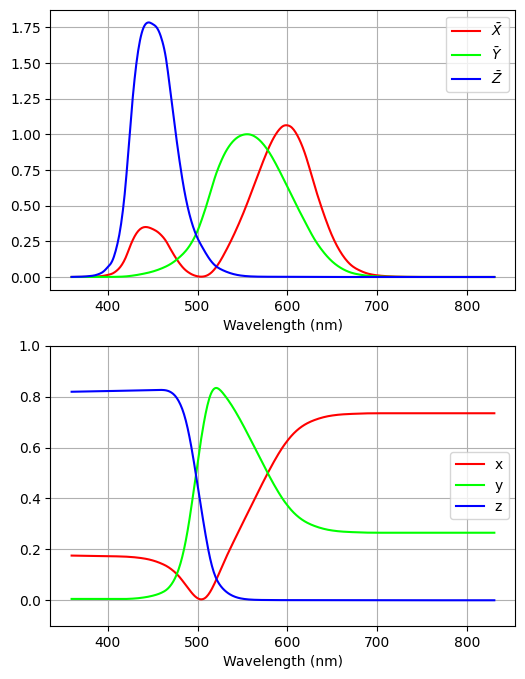

In [3]:
data_filepath = "CIE_xyz_1931_2deg.csv"
L_list, X_list, Y_list, Z_list = get_XYZ_raw_data(data_filepath)
x_list, y_list, z_list = XYZ_to_xyz(X_list, Y_list, Z_list)

fig, [ax_XYZ, ax_xyz] = plt.subplots(2, 1, figsize=(6*1, 4*2), sharex=False)
ax_XYZ.plot(L_list, X_list, color=(1, 0, 0), label=r'$\bar{X}$')
ax_XYZ.plot(L_list, Y_list, color=(0, 1, 0), label=r'$\bar{Y}$')
ax_XYZ.plot(L_list, Z_list, color=(0, 0, 1), label=r'$\bar{Z}$')
ax_XYZ.grid()
ax_XYZ.legend()
ax_XYZ.set_xlabel('Wavelength (nm)')

ax_xyz.plot(L_list, x_list, color=(1, 0, 0), label='x')
ax_xyz.plot(L_list, y_list, color=(0, 1, 0), label='y')
ax_xyz.plot(L_list, z_list, color=(0, 0, 1), label='z')
ax_xyz.grid()
ax_xyz.legend()
ax_xyz.set_xlabel('Wavelength (nm)')
ax_xyz.set_ylim(-0.1, 1)

plt.show()

In [4]:
min(y_list)

0.004774030674490747

In [5]:
x_turnover_idx = np.argmin(x_list)

# Blues
x_seg_0 = x_list[0:x_turnover_idx+1]   
y_seg_0 = y_list[0:x_turnover_idx+1]
interp_0 = interp1d(x_seg_0, y_seg_0)

# Greens to Reds
x_seg_1 = x_list[x_turnover_idx:-1]
y_seg_1 = y_list[x_turnover_idx:-1]
interp_1 = interp1d(x_seg_1, y_seg_1)

# Line of Purples
x_seg_2 = np.linspace(x_list[0], x_list[-1], 100)    
y_seg_2 = np.linspace(y_list[0], y_list[-1], 100)
interp_2 = interp1d(x_seg_2, y_seg_2)


def xy_in_vis_gamut(x, y):
    if x < min(x_list):
        return False
    if x > max(x_list):
        return False
        
    y_max = interp_1(x)  # Upper green -> red curve
    if x <= x_list[0]:
        # Blues
        y_min = interp_0(x)
    else:
        # Line of Purples
        y_min = interp_2(x)

    return y_min <= y <= y_max


def cross(v, w):
    return v[0]*w[1] - v[1]*w[0]

Rxy = np.array((0.64, 0.33))
Gxy = np.array((0.3, 0.6))
Bxy = np.array((0.15, 0.06))
Wxy = np.array((0.3127, 0.329))


def xy_in_sRGB_gamut(x, y):
    xy = np.array((x, y))
    cross_0 = cross(Rxy - xy, Gxy - xy)
    cross_1 = cross(Gxy - xy, Bxy - xy)
    cross_2 = cross(Bxy - xy, Rxy - xy)
    return cross_0 >= 0 and cross_1 >= 0 and cross_2 >= 0

In [6]:
np.cross((1, 0), (0, 1))

array(1)

In [7]:
def add_line_to_ax(vertex_0, vertex_1, npts, ax, **kwargs):
    x_list = np.linspace(vertex_0[0], vertex_1[0], npts, endpoint=True)
    y_list = np.linspace(vertex_0[1], vertex_1[1], npts, endpoint=True)
    ax.plot(x_list, y_list, **kwargs)
    return ax


def add_tick_to_curve(t_tick, t_list, x_list, y_list, tick_width, ax, **tick_kwargs):
    x_interp = interp1d(t_list, x_list)
    y_interp = interp1d(t_list, y_list)
    xy = np.array((x_interp(t_tick), y_interp(t_tick)))
    vx_list = np.gradient(x_list) / np.gradient(t_list)
    vy_list = np.gradient(y_list) / np.gradient(t_list)
    vx = interp1d(t_list, vx_list)(t_tick)
    vy = interp1d(t_list, vy_list)(t_tick)
    v = np.array((vx, vy))
    v_norm = v / np.sqrt(v@v)
    norm_orth = np.array((v_norm[1], -v_norm[0]))
    ax = add_line_to_ax(
        xy - tick_width*norm_orth, 
        xy + tick_width*norm_orth, 
        3, 
        ax, 
        **tick_kwargs,
    )
    return ax


def add_ticks_to_curve(t_ticks, major_ticks, tick_label_dict, t_list, x_list, y_list, minor_width, major_width, ax, **tick_kwargs):
    x_interp = interp1d(t_list, x_list)
    y_interp = interp1d(t_list, y_list)
    for t_tick in t_ticks:
        xy = np.array((x_interp(t_tick), y_interp(t_tick)))               
        if t_tick in major_ticks:
            tick_width = major_width
            if t_tick in tick_label_dict:
                text, offset_x, offset_y, text_kwargs = tick_label_dict[t_tick]
                offset = np.array([offset_x, offset_y])
                text_xy = xy + offset
                ax.text(text_xy[0], text_xy[1], text, **text_kwargs)                
        else:
            tick_width = minor_width
        ax = add_tick_to_curve(t_tick, t_list, x_list, y_list, tick_width, ax, **tick_kwargs)
    return ax


In [8]:
# sRxyY = (0.64, 0.33, 0.2126)
# sGxyY = (0.3, 0.6, 0.7152)
# sBxyY = (0.15, 0.06, 0.0722)

# sRXYZ = xyY_to_XYZ(*sRxyY)
# sGXYZ = xyY_to_XYZ(*sGxyY)
# sBXYZ = xyY_to_XYZ(*sBxyY)

# rgb_to_xyz_mat = np.vstack((sRXYZ, sGXYZ, sBXYZ)).transpose()
# xyz_to_rgb_mat = np.linalg.inv(rgb_to_xyz_mat)


In [9]:
def ccw(p0, p1, p2):
    return (p2[1]-p0[1]) * (p1[0]-p0[0]) > (p1[1]-p0[1]) * (p2[0]-p0[0])


def do_line_segments_intersect(line0, line1):
    p0, p1, = line0
    p2, p3 = line1
    return ccw(p0, p2, p3) != ccw(p1, p2, p3) and ccw(p0, p1, p2) != ccw(p0, p1, p3)


def get_intersection_point(line0, line1):
    xdiff = (line0[0][0] - line0[1][0], line1[0][0] - line1[1][0])
    ydiff = (line0[0][1] - line0[1][1], line1[0][1] - line1[1][1])

    div = np.cross(xdiff, ydiff)
    if div == 0:
       raise Exception('lines do not intersect')

    d = (np.cross(*line0), np.cross(*line1))
    x = np.cross(d, xdiff) / div
    y = np.cross(d, ydiff) / div
    return x, y


def get_projected_xy_in_sRGB(x, y):
    xy = np.array((x, y))
    wxy = np.array(Wxy)
    if xy_in_sRGB_gamut(x, y):
        return x, y
        
    line_xy = (wxy, xy)
    line_RG = ((Rxy[0], Rxy[1]), (Gxy[0], Gxy[1]))
    line_GB = ((Gxy[0], Gxy[1]), (Bxy[0], Bxy[1]))
    line_BR = ((Bxy[0], Bxy[1]), (Rxy[0], Rxy[1]))
    if do_line_segments_intersect(line_xy, line_RG):
        intersection_point = get_intersection_point(line_xy, line_RG)
    elif do_line_segments_intersect(line_xy, line_GB):
        intersection_point = get_intersection_point(line_xy, line_GB)
    elif do_line_segments_intersect(line_xy, line_BR):
        intersection_point = get_intersection_point(line_xy, line_BR)        
    else:
        raise ValueError('so bad')
    return wxy + (intersection_point - wxy)*0.99
    

In [10]:
def spectrum_to_XYZ(lambda_list, spectrum_list):
    spectrum_interp = interp1d(lambda_list, spectrum_list)
    X = sum(spectrum_interp(L_list) * X_list * np.mean(np.gradient(L_list)))
    Y = sum(spectrum_interp(L_list) * Y_list * np.mean(np.gradient(L_list)))
    Z = sum(spectrum_interp(L_list) * Z_list * np.mean(np.gradient(L_list)))
    return X, Y, Z

c = physical_constants['speed of light in vacuum'][0]
h = physical_constants['Planck constant'][0]
kb = physical_constants['Boltzmann constant'][0]


def blackbody_spectrum(wavelength_nm, temp_K):
    T = temp_K
    lam_m = wavelength_nm * 1e-9
    return (2*h*c**2/lam_m**5) * 1/(np.exp(h*c/(lam_m*kb*T)) - 1)


def blackbody_XYZ(temp_K):
    spectrum = blackbody_spectrum(np.array(L_list), temp_K)
    return spectrum_to_XYZ(L_list, spectrum)


def blackbody_xyY(temp_K):
    return XYZ_to_xyY(*blackbody_XYZ(temp_K))

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Visible Gamut spectral boundary
ax.plot(x_list, y_list, marker='', linestyle='-', color='k', zorder=2.1)

L_tick_offsets = {
    450: ("450 nm", -0.08, -0.06, {}),
    500: ("500 nm", -0.15, -0.02, {}),
    550: ("550 nm", +0.00, +0.04, {}),
    600: ("600 nm", +0.00, +0.04, {}),
    650: ("650 nm", +0.00, +0.04, {}),
}
add_ticks_to_curve(np.arange(450, 651, 10), [450, 500, 550, 600, 650], L_tick_offsets, L_list, x_list, y_list, 0.01, 0.03, ax, color='k', zorder=2.3)

# Line of purples
blue_terminus = (x_list[0], y_list[0])
red_terminus = (x_list[-1], y_list[-1])
add_line_to_ax(blue_terminus, red_terminus, 3, ax, marker='', linestyle='-', color='k', zorder=2.1)

# sRGB primaries
ax.plot(Rxy[0], Rxy[1], color=(1, 0, 0), marker='o', markeredgecolor='k', zorder=2.3)
ax.plot(Gxy[0], Gxy[1], color=(0, 1, 0), marker='o', markeredgecolor='k', zorder=2.3)
ax.plot(Bxy[0], Bxy[1], color=(0, 0, 1), marker='o', markeredgecolor='k', zorder=2.3)

# White D65 point
ax.plot(Wxy[0], Wxy[1], color=(1, 1, 1), marker='o', markeredgecolor='k', zorder=2.3)

# sRGB gamut
add_line_to_ax(Rxy, Gxy, 3, ax, color=(0.8, 0.8, 0.8), zorder=2.29)
add_line_to_ax(Gxy, Bxy, 3, ax, color=(0.8, 0.8, 0.8), zorder=2.29)
add_line_to_ax(Bxy, Rxy, 3, ax, color=(0.8, 0.8, 0.8), zorder=2.29)

# Color in sRGB gamut
n_steps = 300
x_array = np.linspace(0, 1, n_steps)
y_array = np.linspace(0, 1, n_steps)
color_array = np.zeros((n_steps, n_steps, 4))

for x_idx, x in enumerate(x_array):
    for y_idx, y in enumerate(y_array):
        if xy_in_sRGB_gamut(x, y):
            # sRGB = xyY_to_sRGB(x, y, 0.07)
            
            sRGB = xy_to_rescaled_sRGB(x, y, 1)
            
            # RGB = sRGB_to_RGB(*sRGB)
            # _, Y, _ = RGB_to_XYZ(*RGB)
            # sRGB = xyY_to_sRGB(Wxy[0], Wxy[1], Y)
            
            a = 1
        elif xy_in_vis_gamut(x, y):
            closest_x, closest_y = get_projected_xy_in_sRGB(x, y)
            sRGB = xy_to_rescaled_sRGB(closest_x, closest_y, 0.5)

            a = 1
            # sRGB = (0, 0, 0)
        else:
            sRGB = (0, 0, 1)
            a = 0
        color_array[y_idx, x_idx, :] = sRGB + (a,)

ax.imshow(color_array, extent=(0, 1, 0, 1), origin='lower', zorder=2.1)

# Planckian Locus
temp_list = np.arange(1e3, 100e3+1, 100)
temp_x_list = []
temp_y_list = []
for temp in temp_list:
    x, y, _ = blackbody_xyY(temp)
    temp_x_list.append(x)
    temp_y_list.append(y)
ax.plot(temp_x_list, temp_y_list, color='k', zorder=2.29, alpha=0.5)

planck_tick_dict = {
    2000: ('2000 K', -0.03, -0.05, {}),
    4000: ('4000 K', -0.00, -0.045, {}),
    6000: ('6000 K', +0.01, -0.04, {}),
    10000: ('10000 K', +0.01, -0.04, {}),
    100000: ('$\infty$', 0, -0.035, {'fontsize': 16}),
}
temp_ticks = np.arange(1e3, 100e3+1, 1000)
temp_major_ticks = [2000, 4000, 6000, 10000, 100000]
temp_major_ticks = list(temp_major_ticks) + [100e3]
add_ticks_to_curve(temp_ticks, temp_major_ticks, planck_tick_dict, temp_list, temp_x_list, temp_y_list, 0.01, 0.02, ax, color='k', zorder=2.29, alpha=0.5)
# xy ticks and labels
ax_ticks = np.arange(-2, 2, 0.05)
ax_tick_labels = []
for ax_tick in ax_ticks:
    if np.isclose(ax_tick % 0.1, 0):
        ax_tick_label = f'{ax_tick:.1f}'
    else:
        ax_tick_label = ''
    ax_tick_labels.append(ax_tick_label)
ax.set_xticks(ax_ticks, labels=ax_tick_labels)
ax.set_yticks(ax_ticks, labels=ax_tick_labels)
ax.grid(which='both')

# xy axes
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(-0.15, 0.85)
ax.set_ylim(-0.05, 0.85)

plt.show()

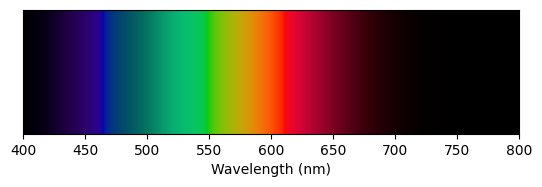

In [12]:
X_interp = interp1d(L_list, X_list)
Y_interp = interp1d(L_list, Y_list)
Z_interp = interp1d(L_list, Z_list)

def monochromatic_to_XYZ(wavelength_nm, scale=1e-3):
    X = scale*X_interp(wavelength_nm)
    Y = scale*Y_interp(wavelength_nm)    
    Z = scale*Z_interp(wavelength_nm)
    return X, Y, Z

fig, ax = plt.subplots(1, 1)

n_x_steps = 300
n_y_steps = 3
color_array = np.zeros((n_y_steps, n_x_steps, 3))
wavelengths = np.linspace(400, 800, n_x_steps)
for x_idx, wavelength in enumerate(wavelengths):
    x, y, Y = XYZ_to_xyY(*monochromatic_to_XYZ(wavelength, scale=0.43))
    new_x, new_y = get_projected_xy_in_sRGB(x, y)
    RGB = xyY_to_sRGB(new_x, new_y, Y)  
    for y_idx in range(n_y_steps):
        color_array[y_idx, x_idx, :] = RGB
ax.imshow(color_array, extent=(min(wavelengths), max(wavelengths), 0, 100))
ax.get_yaxis().set_visible(False)
ax.set_xlabel('Wavelength (nm)')
plt.show()

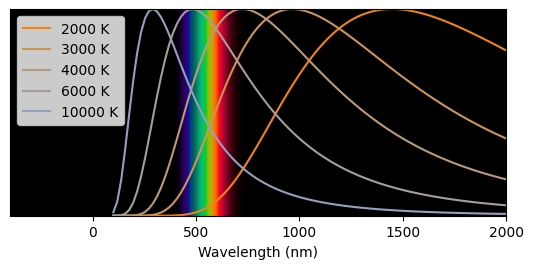

In [13]:
fig, ax = plt.subplots(1, 1)
wavelengths = np.linspace(100, 2000, 100)
ax.imshow(color_array, extent=(400, 800, 0, 1))
for temp in [2000, 3000, 4000, 6000, 10000]:
    spec = blackbody_spectrum(wavelengths, temp)
    x, y, Y = blackbody_xyY(temp)
    # RGB = xy_to_rescaled_sRGB(x, y, 1)
    RGB = xyY_to_sRGB(x, y, 0.35) 
    
    ax.plot(wavelengths, spec/max(spec), color=RGB, label=f'{temp} K')
ax.set_xlim(-400, 2000)
ax.legend()
ax.set_aspect(1000)
ax.get_yaxis().set_visible(False)
ax.set_xlabel('Wavelength (nm)')
ax.set_facecolor('black')
plt.show()

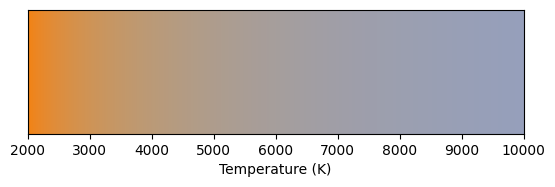

In [14]:
fig, ax = plt.subplots(1, 1)

n_x_steps = 300
n_y_steps = 3
color_array = np.zeros((n_y_steps, n_x_steps, 3))

temps = np.linspace(2000, 10000, n_x_steps)
for x_idx, temp in enumerate(temps):
    x, y, Y = blackbody_xyY(temp)
    # x, y, Y = XYZ_to_xyY(*monochromatic_to_XYZ(wavelength, scale=0.4))
    new_x, new_y = get_projected_xy_in_sRGB(x, y)
    # RGB = xy_to_rescaled_sRGB(new_x, new_y, 1) 
    RGB = xyY_to_sRGB(new_x, new_y, 0.35) 
    # RGB = xy_to_rgb(new_x, new_y, 1)    
    for y_idx in range(n_y_steps):
        color_array[y_idx, x_idx, :] = RGB
ax.imshow(color_array, extent=(min(temps), max(temps), 0, 2000))
ax.get_yaxis().set_visible(False)
ax.set_xlabel('Temperature (K)')
plt.show()

In [15]:
y

0.2882878406911617